# **Đại học Tôn Đức Thắng**
Khoa Công nghệ thông tin
KHAI THÁC DỮ LIỆU VÀ KHAI PHÁ TRI THỨC - 505043
---
    Thành viên:
      Nguyễn Sang Sinh - 51900771
      Trần Hoàng Đăng - 51800850
      Võ Thị Kiều Viễn Đông - 51800855

## **1. The Eclat alogrithm**

### Connect Google Drive & Import Libs

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import os
import matplotlib.pyplot as plt

In [ ]:
drive.mount ('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Massive Dataset Mining/Data

### Load Data

In [ ]:
data = pd.read_csv('store_data.csv', header=None)

In [ ]:
data.head()

In [ ]:
#Get data values to Eclat 
#Get first 1000 values
data_test = data.values[500:600]

In [ ]:
#Data shape
data_test.shape

### Data Processing for Eclat

In [ ]:
#Remove NaN data & Convert values to Array
result = []
temp = []
for i in range(data_test.shape[0]):
  for j in range(data_test.shape[1]):
    if str(data_test[i,j]) != 'nan':
      temp.append(str(data_test[i,j]))
  result.append(temp)
  temp = []

In [ ]:
#Get P 1-itemsets
P = {}
count_tid = 0
for trans in result:
  for item in trans:
    if item in P:
      P[item].append(count_tid) 
    else:
      P[item] = [count_tid]
  count_tid+=1

In [ ]:
#Print 10 itemset first
count = 0
for itemset in P.items():
  if (count < 10):
    print(itemset)
    count += 1
  else:
    break

In [ ]:
#Filtering itemset < minsup
minsup = 3
for key, value in list(P.items()):
  if (len(value) < minsup):
    del P[key]

In [ ]:
#Print itemset after filtering
P.items()

### Eclat Algorithm

In [ ]:
#Union function
def Union_original(lst1, lst2):
  if (type(lst1) == str):
    lst = [lst1] + [lst2]
  else:
    lst = lst1 + lst2
  return list(set(lst))

In [ ]:
#Intersection function
def Intersection( lst1, lst2 ):
    return [value for value in lst1 if value in lst2]

In [ ]:
#Eclat function
def Eclat(P, minsup, F):
  index_a = 1
  for Xa, tXa in P.items():
    index_b = 0
    F.append([(Xa), tXa, len(tXa)])
    Pa = {}
    for Xb, tXb in P.items():
      index_b += 1
      if (index_b > index_a):
        Xab = Union_original(Xa,Xb)
        tXab = Intersection(tXa, tXb)
        if (len(tXab) > minsup):
          Pa[tuple(Xab)] = tXab
    index_a += 1
    if (len(Pa) != 0):
      Eclat(Pa, minsup, F)
  return F

In [ ]:
F = [] #Initial F
minsup = 2 #Initial minsup
Associate_Itemset = Eclat(P,minsup,F)

In [ ]:
#Print result
Associate_Itemset

In [ ]:
#Print last result 
Associate_Itemset[50:]

## **2. Implement the crawling task**

### Crawling data

Hàm **scrape_stock_symbols** dùng để crawl dữ liệu từ trang web cafef.vn. 3 thông số truyền vào bao gồm:
  - name: tên doanh nghiệp
  - category: loại kết quả hoạt động kinh doanh của doanh nghiệp đó
  - year: năm cần crawl để lấy dữ liệu
Các dữ liệu cần crawl bao gồm các quý trong năm cần lấy sẽ được thêm vào list **quarter** và các thông số dữ liệu của năm đó sẽ được thêm vào list **data**.

In [ ]:
def scrape_stock_symbols(name, category, year):
    URL = 'https://s.cafef.vn/bao-cao-tai-chinh/'+name+'/'+category+'/'+year+'/4/0/0/ket-qua-hoat-dong-kinh-doanh-cong-ty-co-phan-tap-doan-hoa-phat.chn'
    soup = BeautifulSoup(requests.get(URL).text, 'html.parser')
    strQuarter = soup.find_all('table', attrs={'id':'tblGridData'})
    strData = soup.find_all('table', attrs={'id':'tableContent'})
  
    for i in strQuarter:
        cols = i.find_all('td', attrs={'class':'h_t'})
        cols = [ele.text.strip() for ele in cols]
        quarter.append([ele for ele in cols if ele])
      
    for i in strData:
        cols = i.find_all('td', attrs={'class':'b_r_c'})
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
      
    return (quarter, data)

Hàm **data_to_csv** sẽ được dùng để chuyển đổi kết quả sang file csv. Thông số dữ liệu truyền vào bao gồm:
  - quarter: các quý trong năm cần crawl
  - data: dữ liệu kết quả kinh doanh
  - year: năm cần crawl
  - path: đường dẫn chưa file dữ liệu sau khi xử lý
  - name: tên doanh nghiệp
  - category: loại kết quả hoạt động kinh doanh

In [ ]:
def data_to_csv(quarter, data, year, path, name, category):
    quarter_len = 4
    if (year == '2021'):
        quarter_len = 3
    data_output = []
    data_row = []
    for i in data[0]:
        if ' ' in i:
          if len(data_row) > 2:
              data_output.append(data_row)
          data_row = []
          data_row.append(i)
        else:
            data_row.append(i)
    with open(path + name + '-' + category + '-' + year + '.csv', 'w+', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(list(['Thông số']) + quarter[0][:quarter_len])
        for i in data_output:
            writer.writerow(i)

Để lấy được dữ liệu, người dùng cần truyền vào khoảng thời gian cần lấy dữ liệu bao gồm năm bắt đầu và năm kết thúc lần lượt qua các biến **startYear** và **endYear**.

List **report** để chức các kết quả mà người dùng cần crawl. Trong đề tài này, chúng em cần crawl dữ liệu từ trang **Kết quả hoạt động kinh doanh** và **Cân đối kế toán** nên thông số truyền vào sẽ là **IncSta** và **BSheet**.
**name** là tên doanh nghiệp

Ví dụ:
https://s.cafef.vn/bao-cao-tai-chinh/HPG/IncSta/2021/4/0/0/ket-qua-hoat-dong-kinh-doanh-cong-ty-co-phan-tap-doan-hoa-phat.chn sẽ lấy kết quả hoạt động kinh doanh từ doanh nghiệp HPG trong năm 2021.

Sau khi có dữ liệu bao gồm tên doanh nghiệp, thể loại kết quả và năm thì dữ liệu sẽ được gửi đến các hàm **scarpe_stock_symbols** và **data_to_csv** để xử lý và in ra kết quả.


In [ ]:
startYear = 2018
endYear = 2021

report = ['IncSta' , 'BSheet']
name = 'HPG'

for category in report:
    if (category == 'IncSta'):
        output_path = 'Họat động kinh doanh/'
    else:
        output_path = 'Cân đối kế toán/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for year in range(startYear, endYear+1):
        quarter = []
        data = []
        (quarter, data) = scrape_stock_symbols(name, category, str(year))
        data_to_csv(quarter, data, str(year), output_path, name, category)
print('Done!')

Done!


### Visualize

In [ ]:
#Đọc dữ liệu từ các file cần visualize
hdkd_2018 = pd.read_csv('/content/Họat động kinh doanh/HPG-IncSta-2018.csv', header=0)
hdkd_2019 = pd.read_csv('/content/Họat động kinh doanh/HPG-IncSta-2019.csv', header=0)
hdkd_2020 = pd.read_csv('/content/Họat động kinh doanh/HPG-IncSta-2020.csv', header=0)
hdkd_2021 = pd.read_csv('/content/Họat động kinh doanh/HPG-IncSta-2021.csv', header=0)

In [ ]:
hdkd_2020.drop(index=hdkd_2020.index[8], axis=0, inplace=True)
hdkd_2021.drop(index=hdkd_2021.index[8], axis=0, inplace=True)

In [ ]:
# Lấy dữ liệu từ Doanh thu bán hàng và cung cấp dịch vụ
rev2018 = hdkd_2018[0:].iloc[0][1:]
rev2019 = hdkd_2019[0:].iloc[0][1:]
rev2020 = hdkd_2020[0:].iloc[0][1:]
rev2021 = hdkd_2021[0:].iloc[0][1:]

# Lấy dữ liệu từ Lợi nhuận sau thuế thu nhập doanh nghiệp
pro2018 = hdkd_2018[1:].iloc[16][1:]
pro2019 = hdkd_2019[1:].iloc[16][1:]
pro2020 = hdkd_2020[1:].iloc[16][1:]
pro2021 = hdkd_2021[1:].iloc[16][1:]

#pro dùng để hợp nhất các dữ liệu lợi nhuận của các năm
pro = [pro2018,pro2019,pro2020,pro2021]
pro = pd.concat(pro)

#rev dùng để hợp nhất các dữ liệu doanh thu của các năm
rev = [rev2018,rev2019,rev2020,rev2021]
rev = pd.concat(rev)

In [ ]:
pro_values = []
for i in pro.values:
  new = i.replace(',', '')
  pro_values.append(int(new))
  
rev_values = []
for i in rev.values:
  new = i.replace(',', '')
  rev_values.append(int(new))

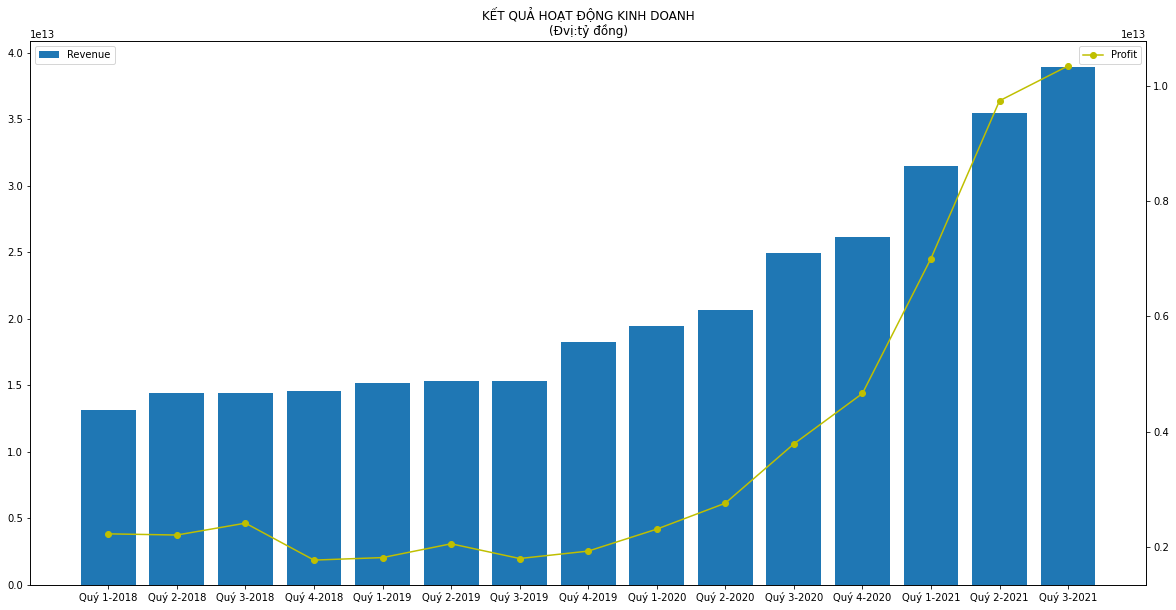

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(rev.keys(),rev_values)
plt.legend(['Revenue'],loc=2)
plt.twinx()
plt.plot(pro.keys(), pro_values, color='y', marker='o')
plt.legend(['Profit'],loc=1)
plt.title('KẾT QUẢ HOẠT ĐỘNG KINH DOANH\n(Đvị:tỷ đồng)')
plt.show()

## **3. Implement the crawling task**

### Visualize

In [ ]:
cdkt_2021 = pd.read_csv('/content/Cân đối kế toán/HPG-BSheet-2021.csv', error_bad_lines=False)
cdkt_2020 = pd.read_csv('/content/Cân đối kế toán/HPG-BSheet-2020.csv', error_bad_lines=False)
cdkt_2019 = pd.read_csv('/content/Cân đối kế toán/HPG-BSheet-2019.csv', error_bad_lines=False)
cdkt_2018 = pd.read_csv('/content/Cân đối kế toán/HPG-BSheet-2018.csv', error_bad_lines=False)

b'Skipping line 3: expected 4 fields, saw 8\n'
b'Skipping line 3: expected 5 fields, saw 10\n'
b'Skipping line 3: expected 5 fields, saw 10\n'
b'Skipping line 3: expected 5 fields, saw 10\n'


In [ ]:
#Lấy dữ liệu TÀI SẢN NGẮN HẠN
tsnh2018 = cdkt_2018[0:].iloc[0][1:]
tsnh2019 = cdkt_2019[0:].iloc[0][1:]
tsnh2020 = cdkt_2020[0:].iloc[0][1:]
tsnh2021 = cdkt_2021[0:].iloc[0][1:]

#Lấy dữ liệu Tài sản cố định
tscd2018 = cdkt_2018[1:].iloc[21][1:]
tscd2019 = cdkt_2019[1:].iloc[21][1:]
tscd2020 = cdkt_2020[1:].iloc[21][1:]
tscd2021 = cdkt_2021[1:].iloc[21][1:]

#Lấy dữ liệu Phải thu về cho vay dài hạn
ktdh2018 = cdkt_2018[0:].iloc[19][1:]
ktdh2019 = cdkt_2019[0:].iloc[19][1:]
ktdh2020 = cdkt_2020[0:].iloc[19][1:]
ktdh2021 = cdkt_2021[0:].iloc[19][1:]

#Lấy dữ liệu Chi phí sản xuất, kinh doanh dở dang dài hạn
ttnhl2018 = cdkt_2018[0:].iloc[32][1:]
ttnhl2019 = cdkt_2019[0:].iloc[32][1:]
ttnhl2020 = cdkt_2020[0:].iloc[32][1:]
ttnhl2021 = cdkt_2021[0:].iloc[32][1:]

#tsnh dùng để hợp nhất các dữ liệu TÀI SẢN NGẮN HẠN
tsnh = [tsnh2018,tsnh2019,tsnh2020,tsnh2021]
tsnh = pd.concat(tsnh)

#tscd dùng để hợp nhất các dữ liệu Tài sản cố định
tscd = [tscd2018,tscd2019,tscd2020,tscd2021]
tscd = pd.concat(tscd)

#ktdh dùng để hợp nhất các dữ liệu Phải thu về cho vay dài hạn
ktdh = [ktdh2018,ktdh2019,ktdh2020,ktdh2021]
ktdh = pd.concat(ktdh)

#ttnhl dùng để hợp nhất các dữ liệu Chi phí sản xuất, kinh doanh dở dang dài hạn
ttnhl = [ttnhl2018,ttnhl2019,ttnhl2020,ttnhl2021]
ttnhl = pd.concat(ttnhl)

In [ ]:
tsnh_values = []
for i in tsnh.values:
  new = i.replace(',', '')
  tsnh_values.append(int(new))
  
tscd_values = []
for i in tscd.values:
  new = i.replace(',', '')
  tscd_values.append(int(new))

ktdh_values = []
for i in ktdh.values:
  new = i.replace(',', '')
  ktdh_values.append(int(new))
  
ttnhl_values = []
for i in ttnhl.values:
  new = i.replace(',', '')
  ttnhl_values.append(int(new))

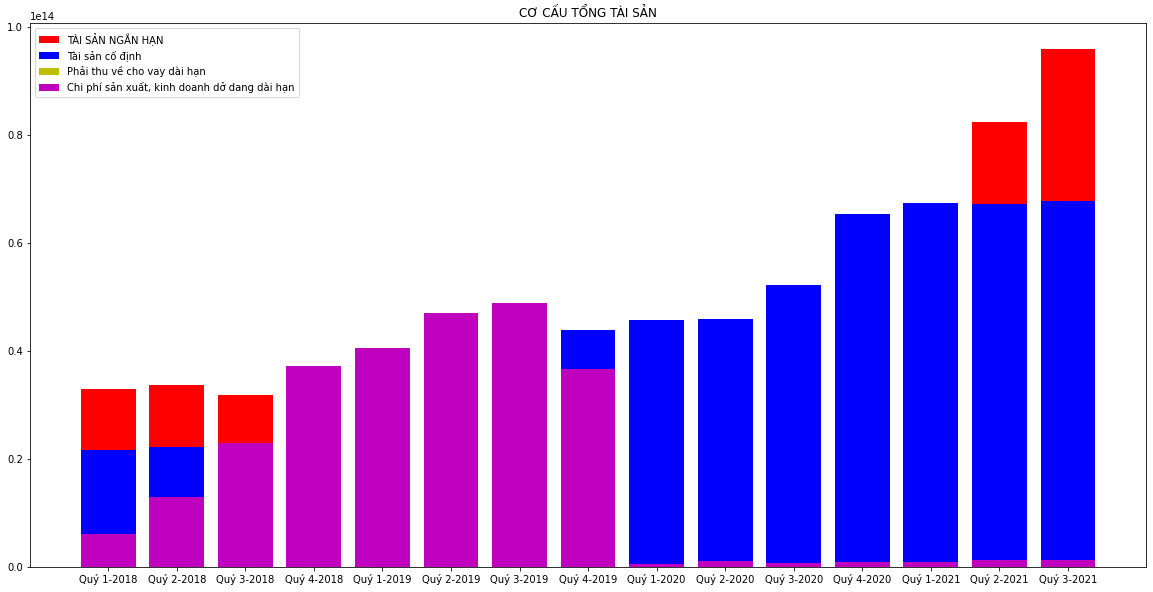

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(tsnh.keys(),tsnh_values,color='r')
plt.bar(tscd.keys(),tscd_values,color='b')
plt.bar(ktdh.keys(),ktdh_values,color='y')
plt.bar(ttnhl.keys(),ttnhl_values,color='m')
plt.title('CƠ CẤU TỔNG TÀI SẢN')
plt.legend(['TÀI SẢN NGẮN HẠN', 'Tài sản cố định','Phải thu về cho vay dài hạn','Chi phí sản xuất, kinh doanh dở dang dài hạn'])
plt.show()